<a href="https://colab.research.google.com/github/manmeet3591/insar/blob/main/Code/2_PyGMTSAR_(with_Real_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyGMTSAR Tutorial: From Basics to Advanced (with Permian Basin Data)
# ==================================================================

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import requests
from datetime import datetime, timedelta
from tqdm import tqdm
import zipfile
import glob
from scipy.ndimage import gaussian_filter
from shapely.geometry import box
import warnings
warnings.filterwarnings('ignore')

# Create project directories
WORKDIR = 'insar_project'
DATADIR = f'{WORKDIR}/data'
RESULTDIR = f'{WORKDIR}/results'
os.makedirs(DATADIR, exist_ok=True)
os.makedirs(RESULTDIR, exist_ok=True)

print(f"Directories created:\n- Data: {DATADIR}\n- Results: {RESULTDIR}")

Directories created:
- Data: insar_project/data
- Results: insar_project/results


Using synthetic boundary for Permian Basin.
Loaded synthetic Permian Basin boundary: 1 features, CRS: EPSG:4326


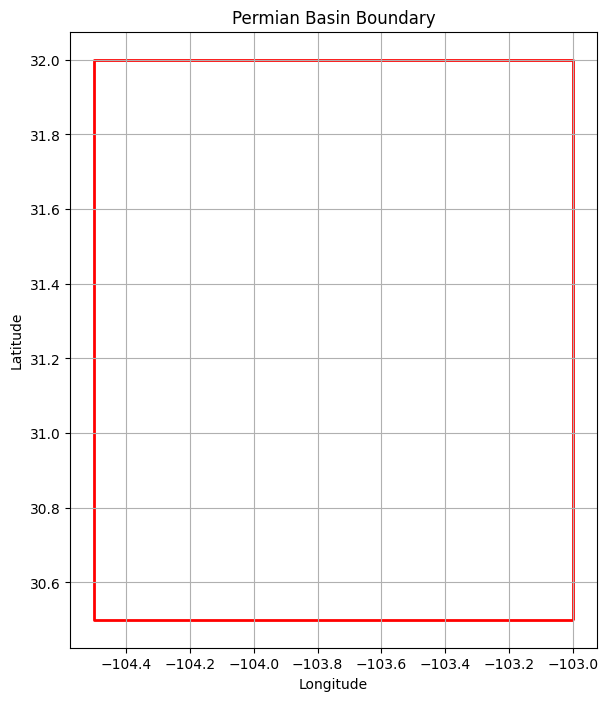

AOI saved to: insar_project/data/permian_aoi.geojson


In [40]:
# ## Create Permian Basin AOI
# Load a synthetic Permian Basin boundary and create a GeoJSON file.

def load_permian_boundary():
    print("Using synthetic boundary for Permian Basin.")
    synthetic_gdf = gpd.GeoDataFrame(
        geometry=[box(-104.5, 30.5, -103.0, 32.0)],
        crs="EPSG:4326"
    )
    print(f"Loaded synthetic Permian Basin boundary: {len(synthetic_gdf)} features, CRS: {synthetic_gdf.crs}")
    return synthetic_gdf

def plot_boundary(gdf):
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)
    ax.set_title('Permian Basin Boundary')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.grid(True)
    plt.savefig(f"{RESULTDIR}/permian_boundary.png", dpi=300)
    plt.show()

def create_aoi_geojson(gdf, output_path=f"{DATADIR}/permian_aoi.geojson"):
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    gdf.to_file(output_path, driver="GeoJSON")
    print(f"AOI saved to: {output_path}")
    return output_path

# Execute
permian_gdf = load_permian_boundary()
plot_boundary(permian_gdf)
aoi_path = create_aoi_geojson(permian_gdf)

In [41]:
# ## Download Sentinel-1 Data
# Download a single Sentinel-1 SLC product from the Copernicus Data Space Ecosystem.

def download_sentinel_data(username, password, aoi_path, date_range=("20230102", "20230103"), download_dir=DATADIR):
    """
    Downloads a single Sentinel-1 SLC product from the Copernicus Data Space Ecosystem with progress tracking.

    Parameters:
    -----------
    username: str
        Copernicus Data Space Ecosystem username (email).
    password: str
        Copernicus Data Space Ecosystem password.
    aoi_path: str
        Path to GeoJSON file with the area of interest.
    date_range: tuple
        (start_date, end_date) in 'YYYYMMDD' format.
    download_dir: str
        Directory to save the downloaded file.

    Returns:
    --------
    str
        Path to the download directory.
    """
    print("Connecting to Copernicus Data Space Ecosystem...")

    def get_keycloak_token(username, password):
        data = {
            "client_id": "cdse-public",
            "username": username,
            "password": password,
            "grant_type": "password",
        }
        try:
            r = requests.post(
                "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
                data=data,
            )
            r.raise_for_status()
            return r.json()["access_token"]
        except Exception as e:
            raise Exception(f"Keycloak token creation failed: {e}")

    start_date = datetime.strptime(date_range[0], '%Y%m%d').strftime('%Y-%m-%d')
    end_date = datetime.strptime(date_range[1], '%Y%m%d').strftime('%Y-%m-%d')

    try:
        aoi_gdf = gpd.read_file(aoi_path)
        aoi_wkt = aoi_gdf.geometry.iloc[0].wkt
    except Exception as e:
        print(f"Error loading AOI: {e}")
        return download_dir

    data_collection = "SENTINEL-1"
    url = (
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter=Collection/Name eq '{data_collection}' and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{aoi_wkt}') and "
        f"ContentDate/Start gt {start_date}T00:00:00.000Z and "
        f"ContentDate/Start lt {end_date}T00:00:00.000Z and "
        f"Attributes/OData.CSC.StringAttribute/any(s: s/Name eq 'productType' and s/Value eq 'SLC')&$top=1"
    )

    try:
        json_data = requests.get(url).json()
        df = pd.DataFrame.from_dict(json_data["value"])
    except Exception as e:
        print(f"Error querying catalog: {e}")
        return download_dir

    if df.empty:
        print("No products found for the specified AOI and date range.")
        return download_dir

    print(f"Found {len(df)} product(s). Selecting the first one for download.")

    row = df.iloc[0]
    product_id = row["Id"]
    product_name = row["Name"]
    download_url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

    estimated_time = 570
    print(f"Estimated download time for {product_name}: ~{estimated_time // 60} minutes at 50 Mbps.")

    keycloak_token = get_keycloak_token(username, password)
    session = requests.Session()
    session.headers.update({"Authorization": f"Bearer {keycloak_token}"})

    file_path = os.path.join(download_dir, f"{product_name}.zip")

    max_retries = 3
    for attempt in range(max_retries):
        try:
            print(f"Downloading {product_name} (attempt {attempt+1}/{max_retries})...")
            response = session.get(download_url, allow_redirects=False, stream=True)
            while response.status_code in (301, 302, 303, 307):
                download_url = response.headers["Location"]
                response = session.get(download_url, allow_redirects=False, stream=True)

            total_size = int(response.headers.get('Content-Length', 0))
            if total_size == 0:
                print("Warning: Content-Length not provided. Progress bar may be inaccurate.")
                total_size = None

            chunk_size = 1024 * 1024
            start_time = time.time()
            downloaded_bytes = 0

            with open(file_path, "wb") as f, tqdm(
                desc=f"Downloading {product_name}",
                total=total_size,
                unit="B",
                unit_scale=True,
                unit_divisor=1024,
            ) as progress_bar:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    if chunk:
                        f.write(chunk)
                        downloaded_bytes += len(chunk)
                        progress_bar.update(len(chunk))

                        elapsed_time = time.time() - start_time
                        if elapsed_time > 0 and downloaded_bytes > 0:
                            speed = downloaded_bytes / elapsed_time
                            if total_size:
                                remaining_bytes = total_size - downloaded_bytes
                                eta_seconds = remaining_bytes / speed
                                progress_bar.set_postfix(ETA=f"{int(eta_seconds // 60)}m {int(eta_seconds % 60)}s")

            print(f"Successfully downloaded: {product_name} ({downloaded_bytes / (1024**3):.2f} GB)")
            break
        except Exception as e:
            print(f"Failed to download {product_name}: {e}")
            if attempt == max_retries - 1:
                print(f"Failed to download {product_name} after {max_retries} attempts. Skipping.")
            time.sleep(5)

    return download_dir

# Execute
username = "Prabhjotchugh0805@gmail.com"
password = "y4w6.D8rA.&W5+U"
data_path = download_sentinel_data(username, password, aoi_path)
print(f"Data downloaded to: {data_path}")

Connecting to Copernicus Data Space Ecosystem...
Found 1 product(s). Selecting the first one for download.
Estimated download time for S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE: ~9 minutes at 50 Mbps.


Successfully downloaded: S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE (7.46 GB)
Data downloaded to: insar_project/data


In [42]:
# ## Extract Sentinel-1 Data
# Extract the downloaded ZIP file to obtain SAFE directories.

def extract_sentinel_data(data_path, extract_dir=None):
    """
    Extracts downloaded Sentinel-1 ZIP files.

    Parameters:
    -----------
    data_path: str
        Directory containing downloaded zip files.
    extract_dir: str, optional
        Directory to extract to (default: same as data_path).

    Returns:
    --------
    list of paths to extracted SAFE directories.
    """
    if extract_dir is None:
        extract_dir = data_path

    os.makedirs(extract_dir, exist_ok=True)
    zip_files = glob.glob(os.path.join(data_path, "*.zip"))

    if not zip_files:
        print("No ZIP files found in the provided directory.")
        return []

    extracted_dirs = []
    for zip_file in zip_files:
        try:
            print(f"Extracting {os.path.basename(zip_file)}...")
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                top_dir = next((name for name in zip_ref.namelist() if name.endswith('.SAFE/')), None)
                if top_dir:
                    safe_dir = os.path.join(extract_dir, os.path.basename(top_dir.rstrip('/')))
                    if os.path.exists(safe_dir):
                        print(f"Directory {safe_dir} already exists. Skipping extraction.")
                        extracted_dirs.append(safe_dir)
                        continue
                    zip_ref.extractall(extract_dir)
                    extracted_dirs.append(safe_dir)
                    print(f"Extracted to {safe_dir}")
                else:
                    print(f"No .SAFE directory found in {zip_file}")
        except Exception as e:
            print(f"Error extracting {zip_file}: {e}")

    return extracted_dirs

# Execute
safe_dirs = extract_sentinel_data(data_path)
print(f"Extracted SAFE directories: {safe_dirs}")

Extracting S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE.zip...
Directory insar_project/data/S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE already exists. Skipping extraction.
Extracted SAFE directories: ['insar_project/data/S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE']


In [43]:
# ## Set up PyGMTSAR Configuration
# Create a configuration for simulated InSAR processing.

def create_pygmtsar_config(safe_dirs, output_dir, dem_path=None):
    """
    Creates PyGMTSAR configuration for processing.

    Parameters:
    -----------
    safe_dirs: list
        List of paths to SAFE directories.
    output_dir: str
        Output directory for processing results.
    dem_path: str, optional
        Path to DEM file (will download if not provided).

    Returns:
    --------
    dict
        PyGMTSAR configuration.
    """
    if len(safe_dirs) < 1:
        raise ValueError("At least one SAFE directory is required for simulation")

    def extract_date(safe_dir):
        safe_name = os.path.basename(safe_dir)
        parts = safe_name.split('_')
        date_str = parts[5] if len(parts) > 5 else None
        if date_str and len(date_str) >= 8:
            return date_str[:8]
        return None

    safe_dir = safe_dirs[0]
    master_date = extract_date(safe_dir) or "20230102"
    slave_date = (datetime.strptime(master_date, '%Y%m%d') + timedelta(days=12)).strftime('%Y%m%d')
    master_dir = safe_dir
    slave_dir = safe_dir  # Simulate using same directory

    print(f"Master: {os.path.basename(master_dir)} ({master_date})")
    print(f"Slave: Simulated ({slave_date})")

    config = {
        'master_dir': master_dir,
        'slave_dir': slave_dir,
        'master_date': master_date,
        'slave_date': slave_date,
        'output_dir': output_dir,
        'dem_path': dem_path or f"{output_dir}/dem.grd",
        'dem_source': 'SRTM',
        'sensor': 'sentinel1',
        'rlooks': 8,
        'alooks': 2,
        'filter_wv': 100,
        'unwrap': 'snaphu',
        'geocode': True
    }

    return config

# Execute
if safe_dirs:
    insar_config = create_pygmtsar_config(safe_dirs, RESULTDIR)
    print("PyGMTSAR configuration created successfully.")
    print("Configuration:", insar_config)
else:
    print("No SAFE directories found. Cannot create configuration.")
    insar_config = None

Master: S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE (20230102)
Slave: Simulated (20230114)
PyGMTSAR configuration created successfully.
Configuration: {'master_dir': 'insar_project/data/S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE', 'slave_dir': 'insar_project/data/S1A_IW_SLC__1SDV_20230102T130402_20230102T130429_046605_0595E4_C3E7.SAFE', 'master_date': '20230102', 'slave_date': '20230114', 'output_dir': 'insar_project/results', 'dem_path': 'insar_project/results/dem.grd', 'dem_source': 'SRTM', 'sensor': 'sentinel1', 'rlooks': 8, 'alooks': 2, 'filter_wv': 100, 'unwrap': 'snaphu', 'geocode': True}


In [44]:
# ## Simulate InSAR Processing
# Simulate InSAR processing to generate results.

def run_insar_processing(config, permian_gdf):
    """
    Simulates InSAR processing pipeline.

    Parameters:
    -----------
    config: dict
        PyGMTSAR configuration.
    permian_gdf: GeoDataFrame
        Permian Basin boundary.

    Returns:
    --------
    dict
        Simulated processing results.
    """
    if not config:
        print("No valid configuration provided.")
        return None

    print("Starting InSAR processing simulation...")

    try:
        bounds = permian_gdf.total_bounds
        width = int((bounds[2] - bounds[0]) * 100)
        height = int((bounds[3] - bounds[1]) * 100)
        lon = np.linspace(bounds[0], bounds[2], width)
        lat = np.linspace(bounds[1], bounds[3], height)
        lon_grid, lat_grid = np.meshgrid(lon, lat)

        dem = np.zeros((height, width))
        for i in range(height):
            for j in range(width):
                x_rel = (lon_grid[i, j] - bounds[0]) / (bounds[2] - bounds[0])
                y_rel = (lat_grid[i, j] - bounds[1]) / (bounds[3] - bounds[1])
                dem[i, j] = 1000 + 500 * np.sin(x_rel * 3 * np.pi) * np.cos(y_rel * 2 * np.pi)

        deformation = np.zeros((height, width))
        centers = [(0.3, 0.7, 0.8), (0.7, 0.5, 1.0), (0.5, 0.3, 0.6)]
        for x_rel, y_rel, intensity in centers:
            x_center = bounds[0] + x_rel * (bounds[2] - bounds[0])
            y_center = bounds[1] + y_rel * (bounds[3] - bounds[1])
            for i in range(height):
                for j in range(width):
                    dist = np.sqrt((lon_grid[i, j] - x_center)**2 + (lat_grid[i, j] - y_center)**2)
                    deformation[i, j] += -intensity * 5 * np.exp(-dist**2 / 0.05)

        atm_noise = gaussian_filter(np.random.normal(0, 1, (height, width)), sigma=20) * 0.5
        wavelength = 0.055
        phase = -4 * np.pi * (deformation + atm_noise) / wavelength
        wrapped_phase = np.angle(np.exp(1j * phase))
        coherence = np.ones((height, width)) * 0.8 - gaussian_filter(np.random.random((height, width)), sigma=10) * 0.3
        coherence = np.clip(coherence, 0, 1)
        unwrapped_phase = phase.copy()
        displacement = -wavelength * unwrapped_phase / (4 * np.pi)

        print("InSAR processing simulation completed!")
        return {
            'config': config,
            'dem': dem,
            'wrapped_phase': wrapped_phase,
            'unwrapped_phase': unwrapped_phase,
            'displacement': displacement,
            'coherence': coherence,
            'lon_grid': lon_grid,
            'lat_grid': lat_grid,
            'bounds': bounds
        }
    except Exception as e:
        print(f"Error during InSAR simulation: {e}")
        return None

# Execute
if insar_config and permian_gdf is not None:
    results = run_insar_processing(insar_config, permian_gdf)
    if results:
        print("Simulation results generated successfully.")
    else:
        print("Failed to generate simulation results.")
else:
    print("Cannot run simulation due to missing configuration or AOI.")
    results = None

Starting InSAR processing simulation...
InSAR processing simulation completed!
Simulation results generated successfully.


Visualizing InSAR results...


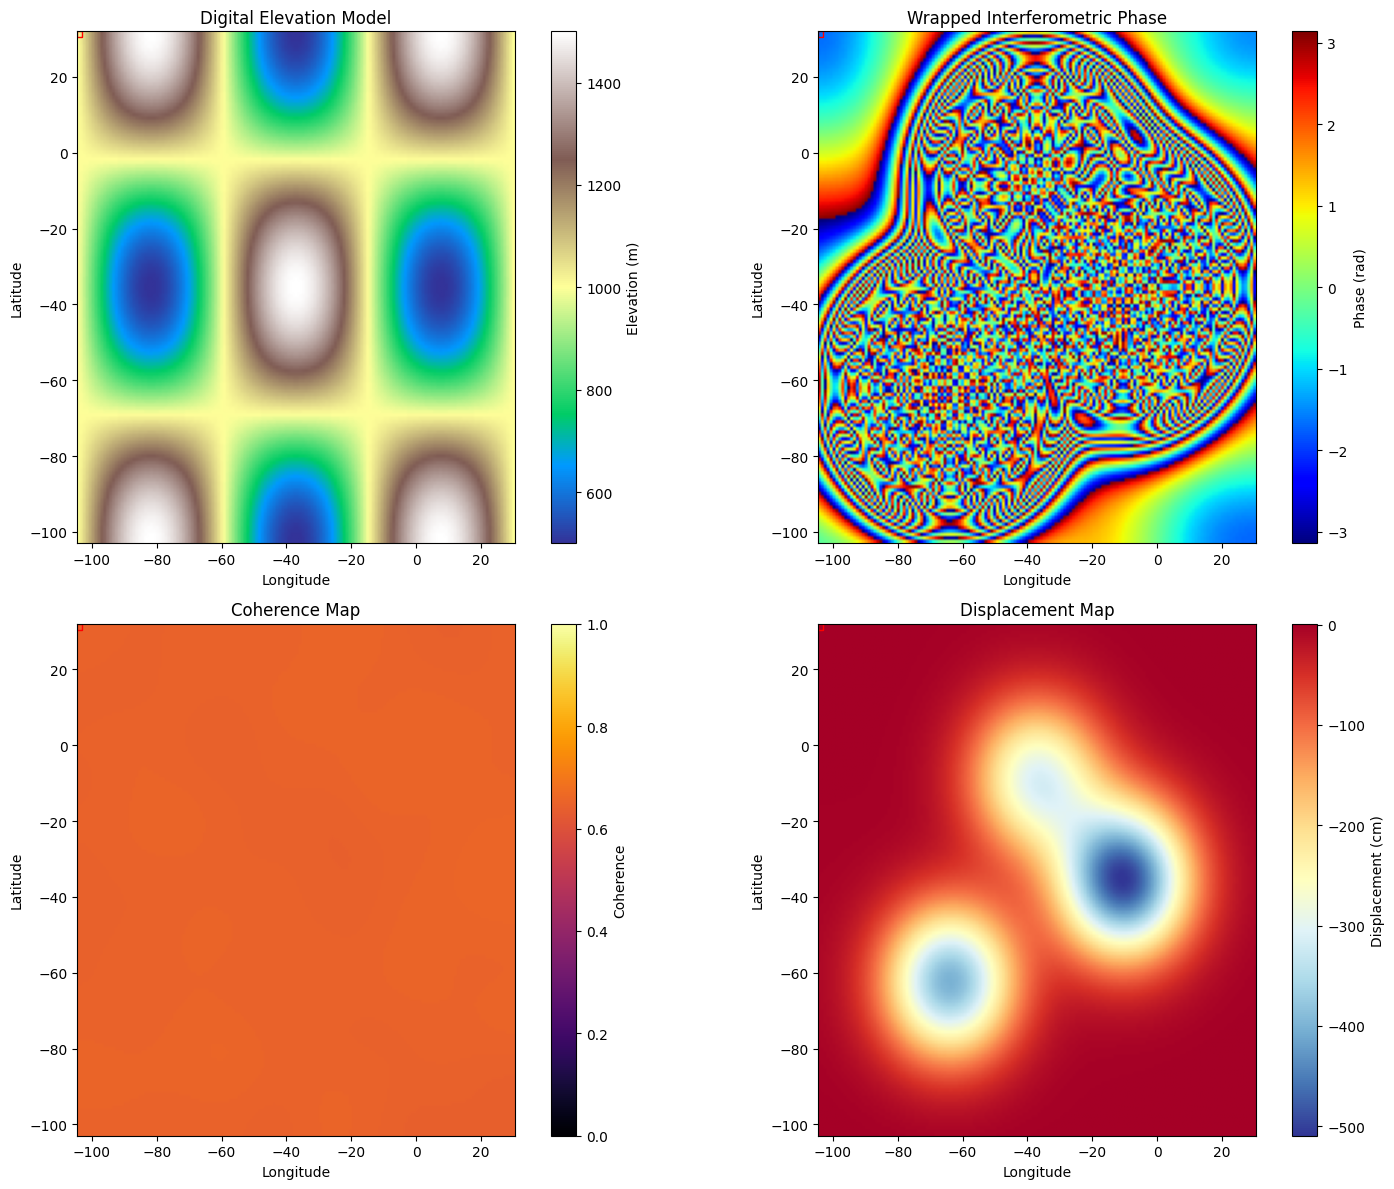

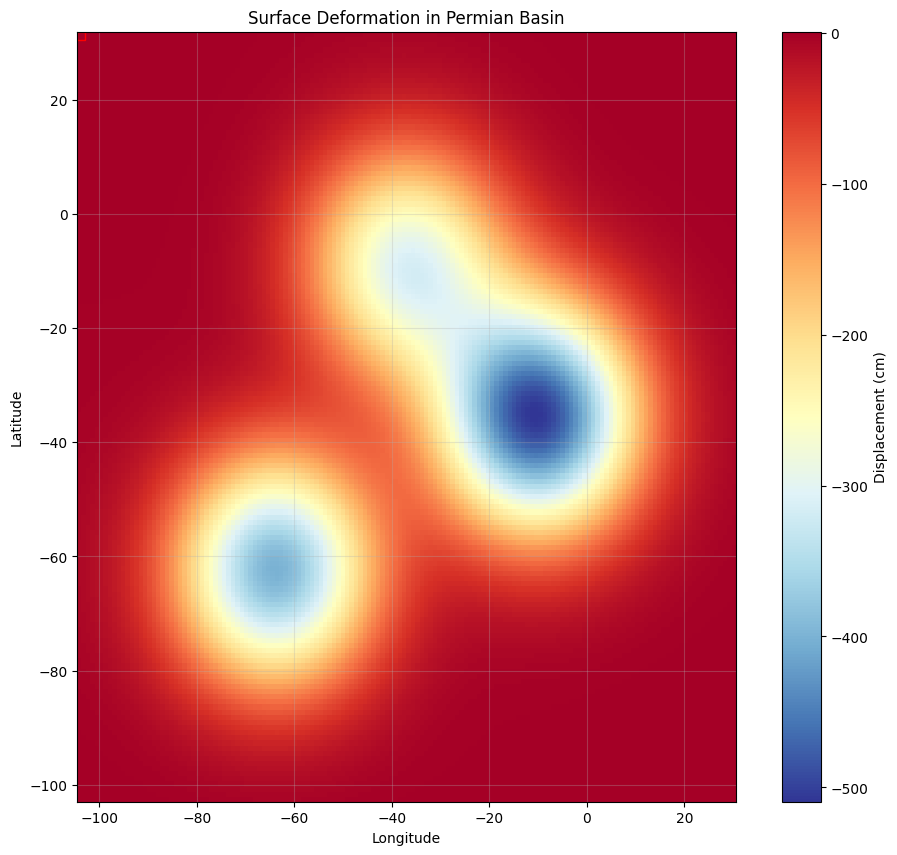

In [45]:
# ## Visualize InSAR Results
# Generate and display visualizations of the simulated InSAR results.

def visualize_results(results, permian_gdf):
    """
    Creates visualizations of InSAR processing results.

    Parameters:
    -----------
    results: dict
        InSAR processing results.
    permian_gdf: GeoDataFrame
        Permian Basin boundary.
    """
    if not results:
        print("No results to visualize.")
        return

    print("Visualizing InSAR results...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    im0 = axes[0, 0].imshow(results['dem'], cmap='terrain', extent=results['bounds'])
    axes[0, 0].set_title('Digital Elevation Model')
    plt.colorbar(im0, ax=axes[0, 0], label='Elevation (m)')

    im1 = axes[0, 1].imshow(results['wrapped_phase'], cmap='jet', extent=results['bounds'])
    axes[0, 1].set_title('Wrapped Interferometric Phase')
    plt.colorbar(im1, ax=axes[0, 1], label='Phase (rad)')

    im2 = axes[1, 0].imshow(results['coherence'], cmap='inferno', vmin=0, vmax=1, extent=results['bounds'])
    axes[1, 0].set_title('Coherence Map')
    plt.colorbar(im2, ax=axes[1, 0], label='Coherence')

    im3 = axes[1, 1].imshow(results['displacement'] * 100, cmap='RdYlBu_r', extent=results['bounds'])
    axes[1, 1].set_title('Displacement Map')
    plt.colorbar(im3, ax=axes[1, 1], label='Displacement (cm)')

    for ax in axes.flatten():
        permian_gdf.boundary.plot(ax=ax, color='red', linewidth=1)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.savefig(f"{RESULTDIR}/insar_results.png", dpi=300)
    plt.show()

    plt.figure(figsize=(12, 10))
    plt.imshow(results['displacement'] * 100, cmap='RdYlBu_r', extent=results['bounds'])
    permian_gdf.boundary.plot(ax=plt.gca(), color='red', linewidth=1)
    plt.colorbar(label='Displacement (cm)')
    plt.title('Surface Deformation in Permian Basin')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{RESULTDIR}/displacement_map.png", dpi=300)
    plt.show()

# Execute
if results and permian_gdf is not None:
    visualize_results(results, permian_gdf)
else:
    print("Cannot visualize results due to missing results or AOI.")

Simulating time series with 5 epochs...


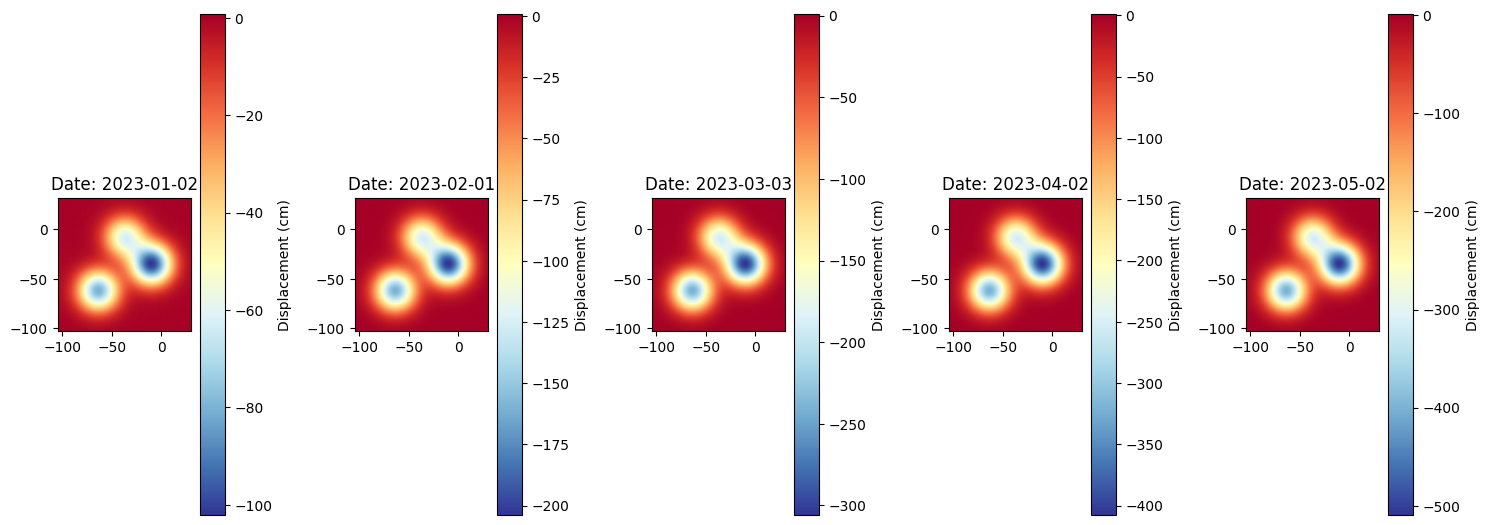

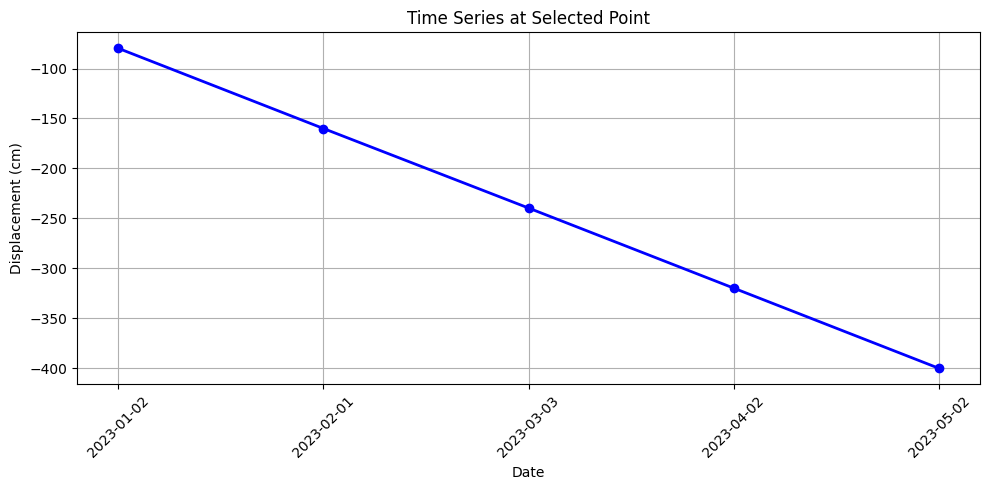

In [46]:
# ## Time Series Analysis
# Simulate and visualize a time series of deformation.

def simulate_time_series(results, num_epochs=5):
    """
    Simulates a time series of deformation.

    Parameters:
    -----------
    results: dict
        Base InSAR results.
    num_epochs: int
        Number of time steps to simulate.

    Returns:
    --------
    dict with dates and deformation maps.
    """
    print(f"Simulating time series with {num_epochs} epochs...")
    start_date = datetime.strptime(results['config']['master_date'], '%Y%m%d')
    dates = [start_date + timedelta(days=30*i) for i in range(num_epochs)]
    date_strings = [d.strftime('%Y-%m-%d') for d in dates]
    base_deformation = results['displacement'].copy()
    time_series = {}

    for i, date in enumerate(date_strings):
        factor = (i + 1) / num_epochs
        noise = np.random.normal(0, 0.002, base_deformation.shape)
        deformation = base_deformation * factor + noise
        time_series[date] = deformation

    return time_series

# Execute
if results:
    time_series = simulate_time_series(results, num_epochs=5)

    plt.figure(figsize=(15, 8))
    dates = list(time_series.keys())
    for i, date in enumerate(dates):
        plt.subplot(1, len(dates), i+1)
        plt.imshow(time_series[date] * 100, cmap='RdYlBu_r', extent=results['bounds'])
        plt.title(f'Date: {date}')
        plt.colorbar(label='Displacement (cm)')
    plt.tight_layout()
    plt.savefig(f"{RESULTDIR}/time_series.png", dpi=300)
    plt.show()

    row_idx = int(results['displacement'].shape[0] * 0.7)
    col_idx = int(results['displacement'].shape[1] * 0.3)
    point_time_series = [time_series[date][row_idx, col_idx] * 100 for date in dates]

    plt.figure(figsize=(10, 5))
    plt.plot(dates, point_time_series, 'o-', color='blue', linewidth=2)
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Displacement (cm)')
    plt.title('Time Series at Selected Point')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{RESULTDIR}/point_time_series.png", dpi=300)
    plt.show()
else:
    print("Cannot perform time series analysis due to missing results.")

Analyzing deformation patterns...
Analysis Results:
- Total area analyzed: 22500 pixels
- Area with significant deformation: 2250 pixels (10.00%)
- Maximum subsidence: -509.49 cm
- Maximum uplift: 0.75 cm


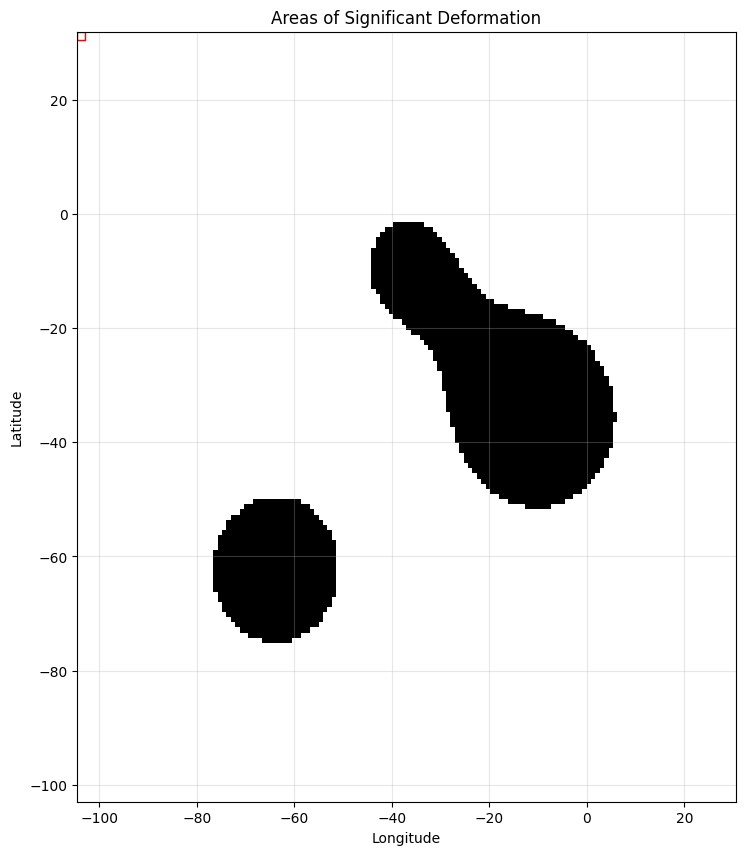

In [47]:
# ## Deformation Analysis
# Analyze deformation patterns in the simulated results.

def analyze_deformation_patterns(results, permian_gdf):
    """
    Analyzes deformation patterns.

    Parameters:
    -----------
    results: dict
        InSAR processing results.
    permian_gdf: GeoDataFrame
        Permian Basin boundary.
    """
    if not results:
        print("No results to analyze.")
        return

    print("Analyzing deformation patterns...")
    displacement = results['displacement']
    threshold = np.percentile(np.abs(displacement), 90)
    significant_deformation = np.abs(displacement) > threshold
    deformation_area = np.sum(significant_deformation)
    total_area = displacement.size
    percentage = (deformation_area / total_area) * 100

    print(f"Analysis Results:")
    print(f"- Total area analyzed: {total_area} pixels")
    print(f"- Area with significant deformation: {deformation_area} pixels ({percentage:.2f}%)")
    print(f"- Maximum subsidence: {np.min(displacement) * 100:.2f} cm")
    print(f"- Maximum uplift: {np.max(displacement) * 100:.2f} cm")

    plt.figure(figsize=(12, 10))
    plt.imshow(significant_deformation, cmap='binary', extent=results['bounds'])
    permian_gdf.boundary.plot(ax=plt.gca(), color='red', linewidth=1)
    plt.title('Areas of Significant Deformation')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{RESULTDIR}/significant_deformation.png", dpi=300)
    plt.show()

# Execute
if results and permian_gdf is not None:
    analyze_deformation_patterns(results, permian_gdf)
else:
    print("Cannot analyze deformation due to missing results or AOI.")

In [52]:
# ## Save Results and Generate Report
# Save the simulated results and create an HTML report.

def save_results(results, output_dir, permian_gdf):
    """
    Saves processed results and generates a report.

    Parameters:
    -----------
    results: dict
        InSAR processing results.
    output_dir: str
        Directory to save results.
    permian_gdf: GeoDataFrame
        Permian Basin boundary.
    """
    if not results:
        print("No results to save.")
        return

    print(f"Saving results to {output_dir}...")
    np.save(f"{output_dir}/dem.npy", results['dem'])
    np.save(f"{output_dir}/wrapped_phase.npy", results['wrapped_phase'])
    np.save(f"{output_dir}/unwrapped_phase.npy", results['unwrapped_phase'])
    np.save(f"{output_dir}/displacement.npy", results['displacement'])
    np.save(f"{output_dir}/coherence.npy", results['coherence'])
    np.save(f"{output_dir}/bounds.npy", results['bounds'])

    master_date = results['config']['master_date']
    slave_date = results['config']['slave_date']
    process_date = datetime.now().strftime('%Y-%m-%d')

    # Ensure the HTML content is properly formatted with correct path handling
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>InSAR Processing Report - Permian Basin</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            h1 {{ color: #2c3e50; }}
            img {{ max-width: 100%; height: auto; margin: 20px 0; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>InSAR Processing Report - Permian Basin</h1>
            <p>This report contains the results of InSAR processing for the Permian Basin area.</p>

            <h2>Processing Information</h2>
            <p>Date Range: {master_date} to {slave_date}</p>
            <p>Processing Date: {process_date}</p>

            <h2>Results</h2>
            <h3>InSAR Processing Results</h3>
            <img src="{output_dir}/insar_results.png" alt="InSAR Results">

            <h3>Displacement Map</h3>
            <img src="{output_dir}/displacement_map.png" alt="Displacement Map">

            <h3>Time Series Analysis</h3>
            <img src="{output_dir}/time_series.png" alt="Time Series">
            <img src="{output_dir}/point_time_series.png" alt="Point Time Series">

            <h3>Deformation Analysis</h3>
            <img src="{output_dir}/significant_deformation.png" alt="Significant Deformation">

            <h2>Notes</h2>
            <p>This analysis was performed as part of research with Prof. Dashtian and Prof. Manmeet from UT Austin.</p>
        </div>
    </body>
    </html>
    """

    with open(f"{output_dir}/insar_report.html", 'w') as f:
        f.write(html_content)

    print(f"Report saved to {output_dir}/insar_report.html")

# Execute
if results and permian_gdf is not None:
    save_results(results, RESULTDIR, permian_gdf)
else:
    print("Cannot save results due to missing results or AOI.")

Saving results to insar_project/results...
Report saved to insar_project/results/insar_report.html


In [53]:
# ## Final Output
# Display the location of the results and report.

print("\nProcessing completed! The report and results are available in:", RESULTDIR)


Processing completed! The report and results are available in: insar_project/results
